<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [183]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

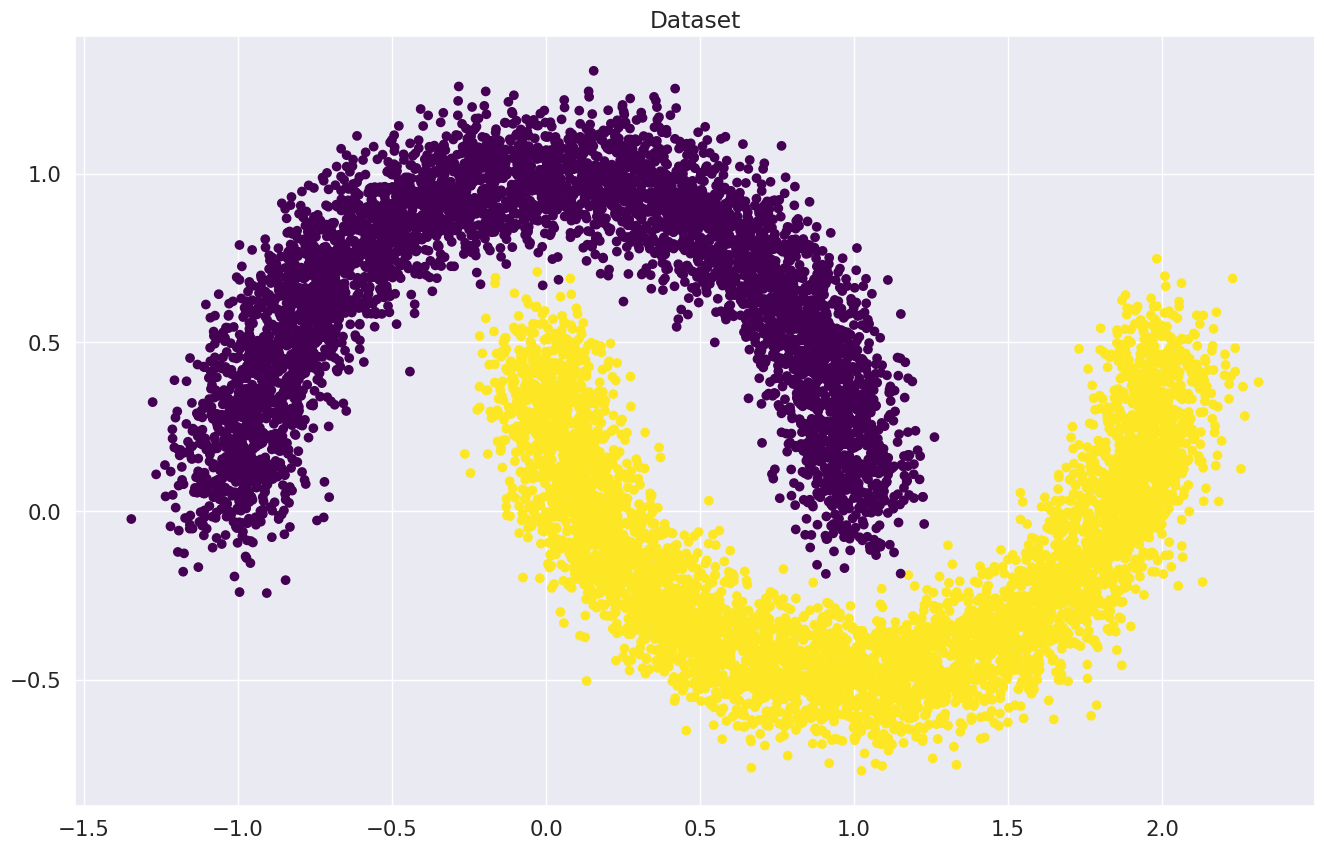

In [184]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [185]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [186]:
X_train_t =  torch.from_numpy(X_train).type(torch.float32)
y_train_t =  torch.from_numpy(y_train).type(torch.float32)
X_val_t =  torch.from_numpy(X_val).type(torch.float32)
y_val_t =  torch.from_numpy(y_val).type(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [187]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоиды берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [188]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [189]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [190]:
amount_parameters = linear_regression.weights.numel()
if linear_regression.bias:
    amount_parameters += linear_regression.bias_term.numel()
amount_parameters

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [191]:
torch.exp

<function torch._VariableFunctionsClass.exp>

In [192]:
from math import exp
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp.squeeze(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1/(1+torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.7890625
Iteration: 100
Batch accuracy: 0.8203125
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.8671875

Iteration: 464.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 696

### Визуализируем результаты

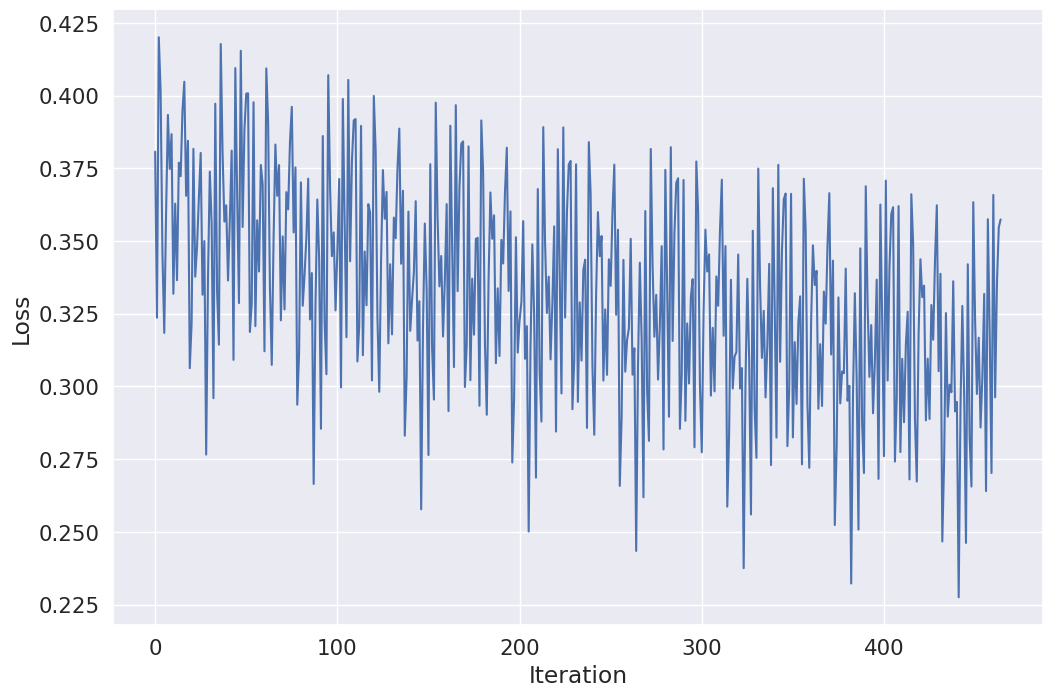

In [193]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

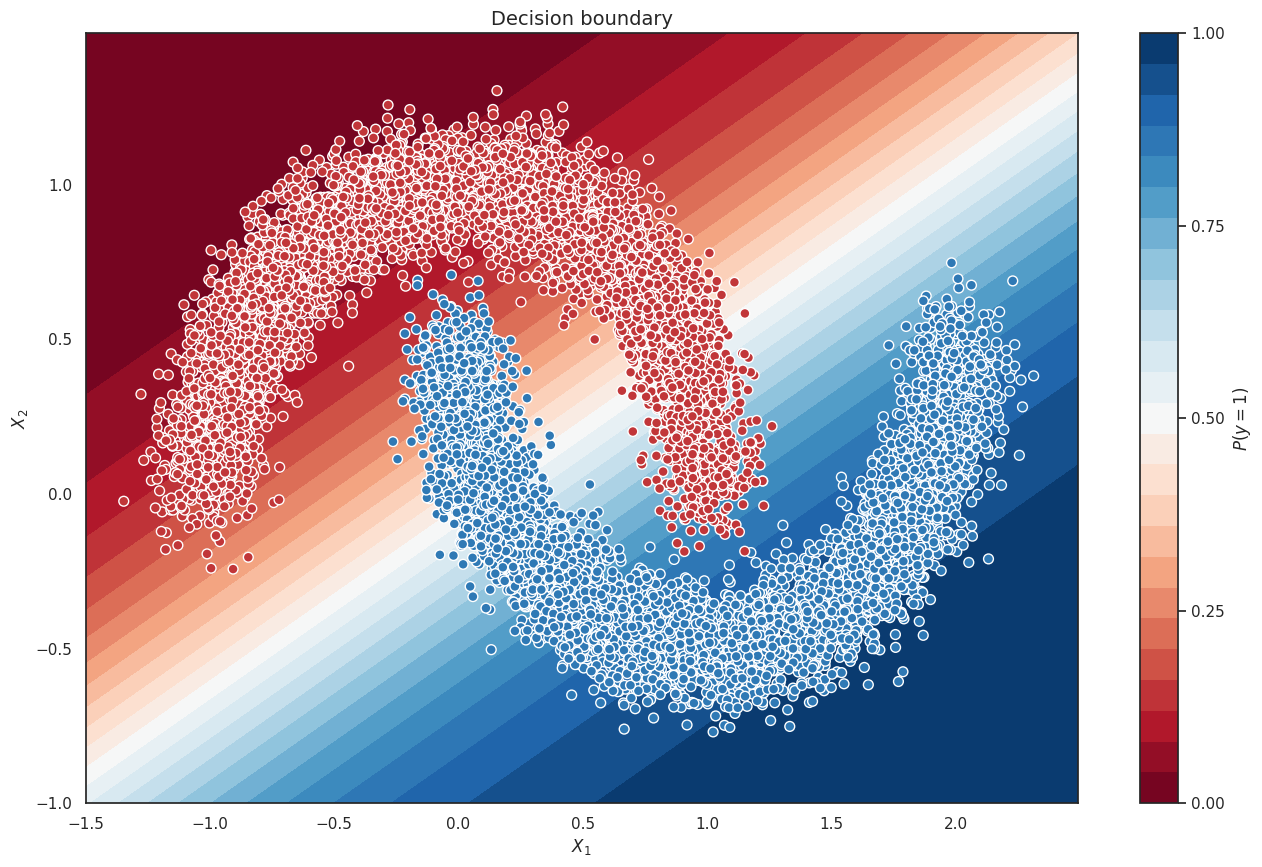

In [194]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [195]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch))
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [196]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)
preds = (predictions > 0.5).astype(int)
accuracy_score(y_val, preds)

0.8556

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8636

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [197]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [198]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [199]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128,10)
)

In [200]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [201]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [202]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
            else:
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds==y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.87965
Loader: valid. Accuracy: 0.9196
Epoch: 2
Loader: train. Accuracy: 0.9412
Loader: valid. Accuracy: 0.9474
Epoch: 3
Loader: train. Accuracy: 0.95905
Loader: valid. Accuracy: 0.9613
Epoch: 4
Loader: train. Accuracy: 0.96795
Loader: valid. Accuracy: 0.9682
Epoch: 5
Loader: train. Accuracy: 0.9743833333333334
Loader: valid. Accuracy: 0.9704
Epoch: 6
Loader: train. Accuracy: 0.97845
Loader: valid. Accuracy: 0.9732
Epoch: 7
Loader: train. Accuracy: 0.9810333333333333
Loader: valid. Accuracy: 0.972
Epoch: 8
Loader: train. Accuracy: 0.9834333333333334
Loader: valid. Accuracy: 0.97
Epoch: 9
Loader: train. Accuracy: 0.985
Loader: valid. Accuracy: 0.9654
Epoch: 10
Loader: train. Accuracy: 0.98595
Loader: valid. Accuracy: 0.9633


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [203]:
elu_accuracy = accuracy["valid"]

In [204]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128,10)
    )



    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    accuracies = []
    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
        epoch_correct=0
        epoch_all=0
        for x_batch, y_batch in dataloader:
          if k =='train':
            model.train()
            optimizer.zero_grad()
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()
          else:
            model.eval()
            with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds==y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

        accuracy[k] = epoch_correct/epoch_all if epoch_all > 0 else 0.0

      print(f"Activation fun: {activation}, Epoch: {epoch + 1}, Validation Accuracy: {accuracy['valid']:.4f}")
      accuracies.append(accuracy["valid"])
    return accuracies


⏰ Просто сравнение из гугла

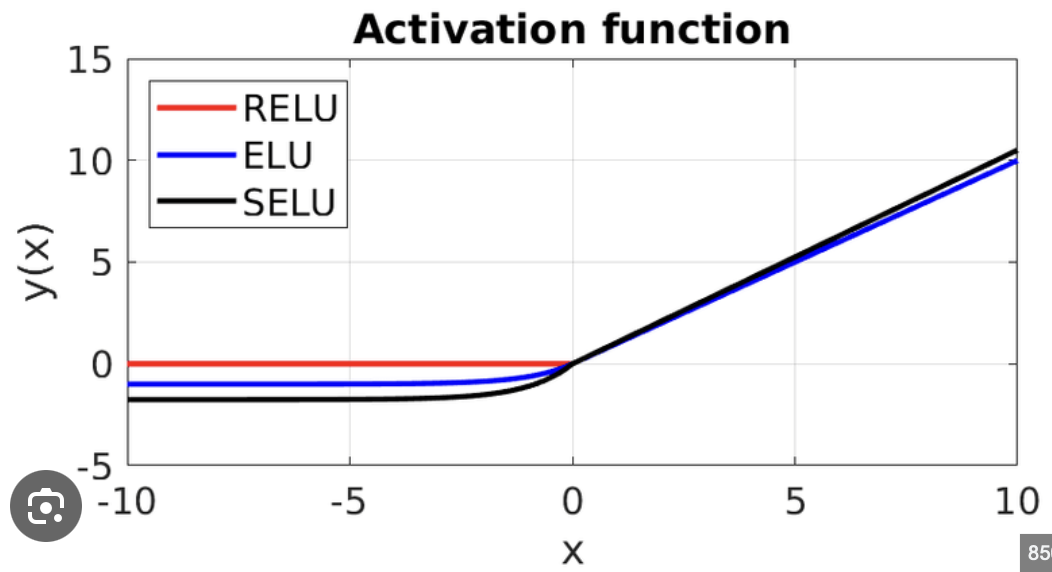

In [205]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU) #курва передай как классы, а не как функция
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
tanh_accuracy = test_activation_function(nn.Tanh)
sigmoid_accuracy = test_activation_function(nn.Sigmoid)
gelu_accuracy = test_activation_function(nn.GELU)

Activation fun: <class '__main__.Identical'>, Epoch: 1, Validation Accuracy: 0.8823
Activation fun: <class '__main__.Identical'>, Epoch: 2, Validation Accuracy: 0.8991
Activation fun: <class '__main__.Identical'>, Epoch: 3, Validation Accuracy: 0.9007
Activation fun: <class '__main__.Identical'>, Epoch: 4, Validation Accuracy: 0.9023
Activation fun: <class '__main__.Identical'>, Epoch: 5, Validation Accuracy: 0.9012
Activation fun: <class '__main__.Identical'>, Epoch: 6, Validation Accuracy: 0.9011
Activation fun: <class '__main__.Identical'>, Epoch: 7, Validation Accuracy: 0.9017
Activation fun: <class '__main__.Identical'>, Epoch: 8, Validation Accuracy: 0.9022
Activation fun: <class '__main__.Identical'>, Epoch: 9, Validation Accuracy: 0.9031
Activation fun: <class '__main__.Identical'>, Epoch: 10, Validation Accuracy: 0.9040
Activation fun: <class 'torch.nn.modules.activation.ReLU'>, Epoch: 1, Validation Accuracy: 0.9155
Activation fun: <class 'torch.nn.modules.activation.ReLU'>, E

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

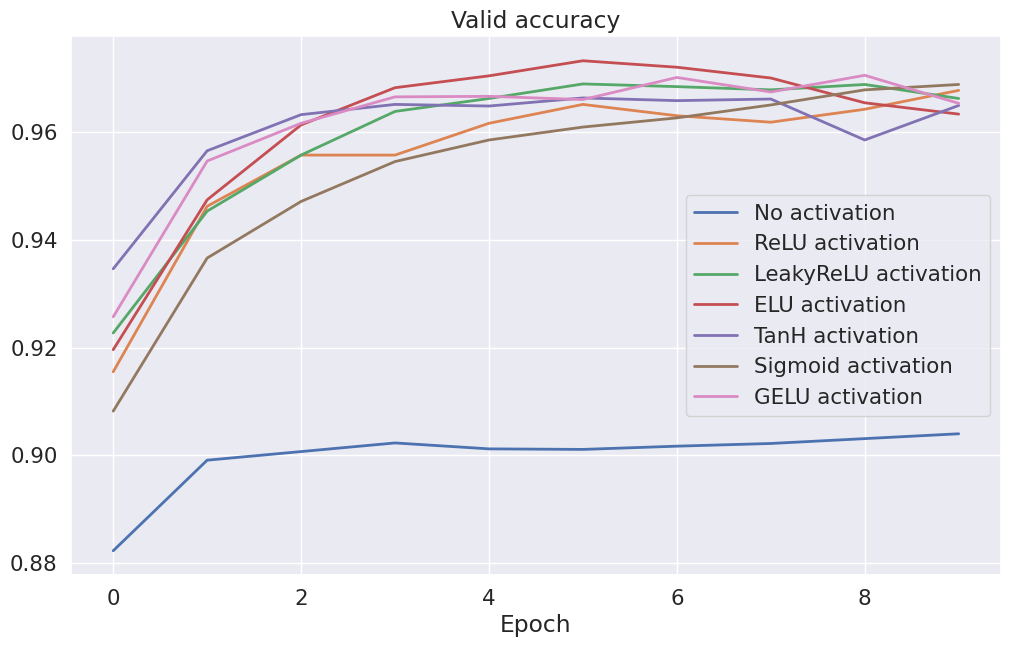

In [225]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 7))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="TanH activation", linewidth=2)
plt.plot(range(max_epochs), sigmoid_accuracy, label="Sigmoid activation", linewidth=2)
plt.plot(range(max_epochs), gelu_accuracy, label="GELU activation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Из всех функций активации (я использовала 7) наилучшие результаты показали функции ReLU, GELU, ELU. Наихудший результат - без функции активации, что вполне ожидаемо.

Сигмоида также была не сильно эффективна на начальных эпохах, но к последним результат выравнивается.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [207]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-11-05 13:50:55--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   260KB/s    in 0.2s    

2024-11-05 13:50:56 (260 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



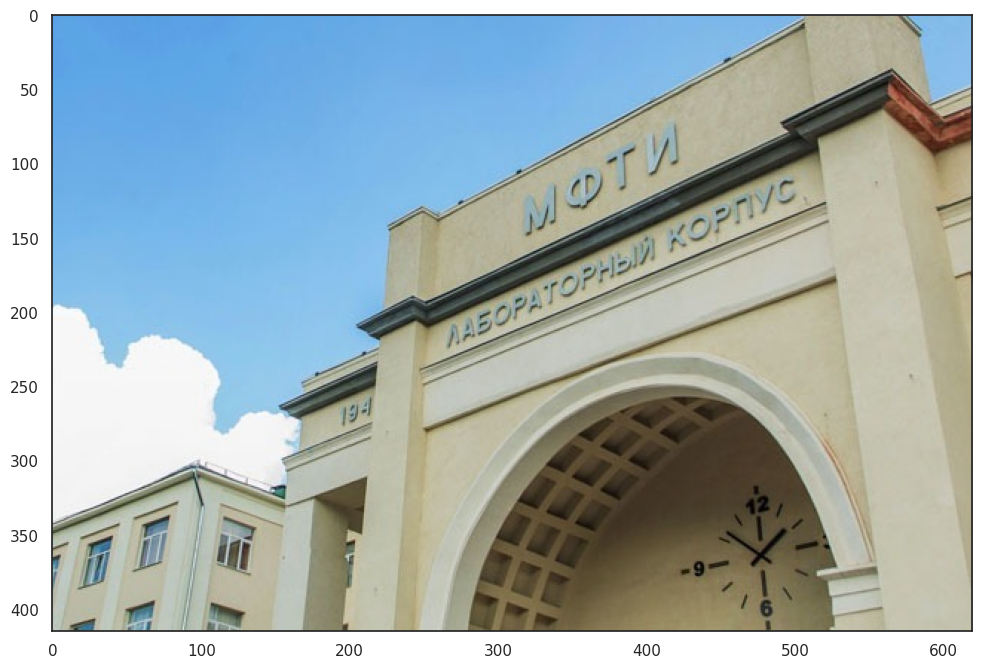

In [208]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [209]:
A_kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [210]:
B_kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [211]:
C_kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [212]:
D_kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [213]:
E_kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [214]:
F_kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

доп строка для доп тензора на пробу

In [215]:
G_kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

In [216]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, kernel)[0]

Пробуем разные тензоры от А до Ф - обожемой ⛽

In [217]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
A_kernel = A_kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, A_kernel)[0]

In [218]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
B_kernel = B_kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, B_kernel)[0]

In [219]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
C_kernel = C_kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, C_kernel)[0]

In [220]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
D_kernel = D_kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, D_kernel)[0]

In [221]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
E_kernel = E_kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, E_kernel)[0]

In [222]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
F_kernel = F_kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)

result = F.conv2d(img_t, F_kernel)[0]

✊ Пробую различные фильтры, чтобы сравнить с дефолтными

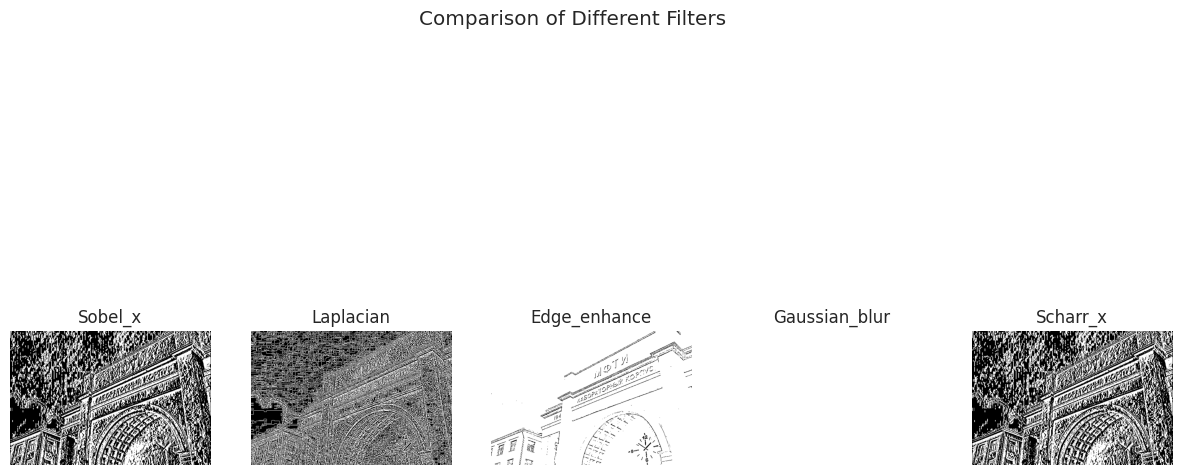

In [223]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)  # [1, H, W, C]
img_t = img_t.permute(0, 3, 1, 2)  # Переводим в формат [1, C, H, W] (где C = 3 для RGB)
img_t = nn.ReflectionPad2d(1)(img_t)

filters = {
    'Sobel_x': torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]).reshape(1, 1, 3, 3).type(torch.float32),

    'Laplacian': torch.tensor([
        [0, -1, 0],
        [-1, 4, -1],
        [0, -1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),

    'Edge_enhance': torch.tensor([
        [-1, -1, -1],
        [-1, 9, -1],
        [-1, -1, -1]
    ]).reshape(1, 1, 3, 3).type(torch.float32),

    'Gaussian_blur': torch.tensor([
        [1/16, 1/8, 1/16],
        [1/8, 1/4, 1/8],
        [1/16, 1/8, 1/16]
    ]).reshape(1, 1, 3, 3).type(torch.float32),

    'Scharr_x': torch.tensor([
        [-3, 0, 3],
        [-10, 0, 10],
        [-3, 0, 3]
    ]).reshape(1, 1, 3, 3).type(torch.float32)
}

filters = {name: kernel.repeat(3, 3, 1, 1) for name, kernel in filters.items()}

results = {}
for name, kernel in filters.items():
    result = F.conv2d(img_t, kernel)
    results[name] = result[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(15, 8))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, len(results), i + 1)
    plt.imshow(result, cmap='gray')
    plt.title(name)
    plt.axis("off")

plt.suptitle("Comparison of Different Filters")
plt.show()


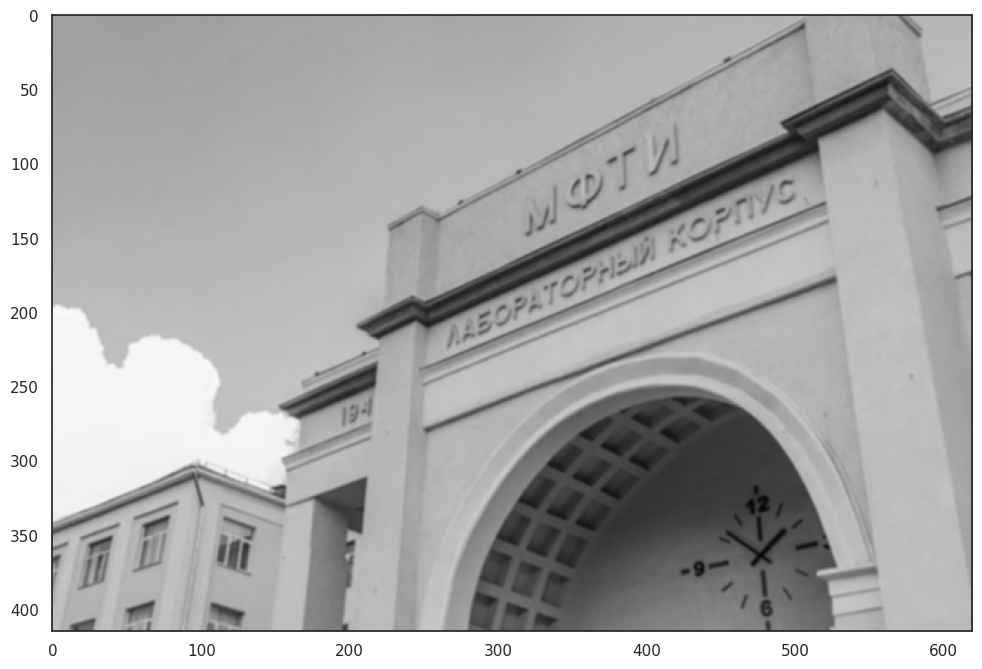

In [164]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

**Ответ:**
1) Размытие - F, Gaussian Blur ( 👉 👈 вот это поворот - по-хорошему блюр Гаусса у меня не сработал (или сработал слишком сильно), но разбираться в этом я, пожалуй, не буду. )

2) Увеличение резкости - E, Edge-Enhance

3) Тождественное преобразование - A

4) Выделение вертикальных границ - B, Sobel_x, Scharr

5) Выделение горизонтальных границ - C, Sobel_y

6) Выделение границ - D, Laplace



### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [226]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 =  nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Сверточный блок 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Уплощение
        x = x.view(-1, 16 * 5 * 5)

        # Полносвязные слои с активацией
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Выходной
        x = self.fc3(x)
        return x

In [227]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [228]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(dim=1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all

        accuracy[k].append(epoch_correct / epoch_all)
        if k == "train":
            print(f"Epoch {epoch + 1} - Train accuracy: {accuracy['train'][-1]:.4f}")
        else:
            print(f"Epoch {epoch + 1} - Validation accuracy: {accuracy['valid'][-1]:.4f}")

lenet_accuracy = accuracy["valid"]


Epoch 1 - Train accuracy: 0.8587
Epoch 1 - Validation accuracy: 0.9582
Epoch 2 - Train accuracy: 0.9652
Epoch 2 - Validation accuracy: 0.9716
Epoch 3 - Train accuracy: 0.9763
Epoch 3 - Validation accuracy: 0.9779
Epoch 4 - Train accuracy: 0.9816
Epoch 4 - Validation accuracy: 0.9818
Epoch 5 - Train accuracy: 0.9850
Epoch 5 - Validation accuracy: 0.9852
Epoch 6 - Train accuracy: 0.9877
Epoch 6 - Validation accuracy: 0.9864
Epoch 7 - Train accuracy: 0.9897
Epoch 7 - Validation accuracy: 0.9868
Epoch 8 - Train accuracy: 0.9913
Epoch 8 - Validation accuracy: 0.9884
Epoch 9 - Train accuracy: 0.9929
Epoch 9 - Validation accuracy: 0.9881
Epoch 10 - Train accuracy: 0.9939
Epoch 10 - Validation accuracy: 0.9869


Сравним с предыдущим пунктом

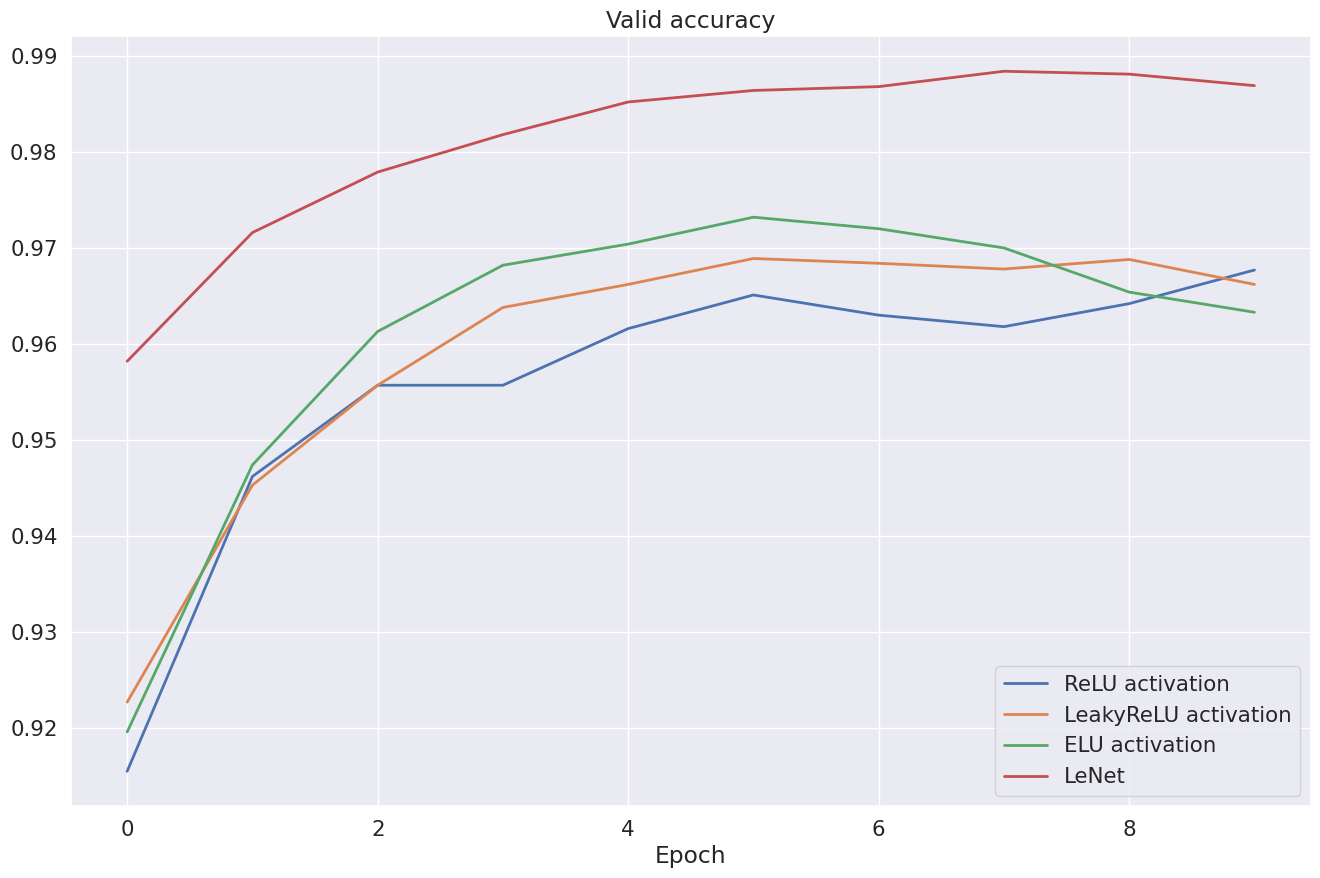

In [229]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.9869
**Вывод:** LeNet показал лучший результат (значительная разница)